<a href="https://colab.research.google.com/github/geoc1234/Tools/blob/main/notebooks/BicycleDynamicsWithSympy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sympy

The bicycle is an interesting system in that it can be modeled with multiple rigid bodies, non-holonomic constraints, and a holonomic constraint. The linearized equations of motion of the Carvallo-Whipple bicycle model are presented and benchmarked in [Meijaard2007]. This example will construct the same linear equations of motion using sympy.physics.mechanics.

In [2]:
import sympy as sm
import sympy.physics.mechanics as me
me.mechanics_printing(pretty_print=True)

##Declaration of Coordinates & Speeds
The simple definition of
 is used in this model. The generalized speeds are:

yaw frame angular rate ,
roll frame angular rate ,
rear wheel frame angular rate (spinning motion) ,
frame angular rate (pitching motion) ,
steering frame angular rate , and
front wheel angular rate (spinning motion) .
Wheel positions are ignorable coordinates, so they are not introduced.

In [3]:
q1, q2, q3, q4, q5 = me.dynamicsymbols('q1 q2 q3 q4 q5')
q1d, q2d, q4d, q5d = me.dynamicsymbols('q1 q2 q4 q5', 1)
u1, u2, u3, u4, u5, u6 = me.dynamicsymbols('u1 u2 u3 u4 u5 u6')
u1d, u2d, u3d, u4d, u5d, u6d = me.dynamicsymbols('u1 u2 u3 u4 u5 u6', 1)


##Declaration of System’s Parameters
The constant parameters of the model are:

In [4]:
WFrad, WRrad, htangle, forkoffset = sm.symbols('WFrad WRrad htangle forkoffset')
forklength, framelength, forkcg1 = sm.symbols('forklength framelength forkcg1')
forkcg3, framecg1, framecg3, Iwr11 = sm.symbols('forkcg3 framecg1 framecg3 Iwr11')
Iwr22, Iwf11, Iwf22, Iframe11 = sm.symbols('Iwr22 Iwf11 Iwf22 Iframe11')
Iframe22, Iframe33, Iframe31, Ifork11 = sm.symbols('Iframe22 Iframe33 Iframe31 Ifork11')
Ifork22, Ifork33, Ifork31, g = sm.symbols('Ifork22 Ifork33 Ifork31 g')
mframe, mfork, mwf, mwr = sm.symbols('mframe mfork mwf mwr')

##Kinematics of the Bicycle
Set up reference frames for the system
N - inertial
Y - yaw
R - roll
WR - rear wheel, rotation angle is ignorable coordinate so not oriented
Frame - bicycle frame
TempFrame - statically rotated frame for easier reference inertia definition
Fork - bicycle fork
TempFork - statically rotated frame for easier reference inertia definition
WF - front wheel, again posses an ignorable coordinate


In [5]:
N = me.ReferenceFrame('N')
Y = N.orientnew('Y', 'Axis', [q1, N.z])
R = Y.orientnew('R', 'Axis', [q2, Y.x])
Frame = R.orientnew('Frame', 'Axis', [q4 + htangle, R.y])
WR = me.ReferenceFrame('WR')
TempFrame = Frame.orientnew('TempFrame', 'Axis', [-htangle, Frame.y])
Fork = Frame.orientnew('Fork', 'Axis', [q5, Frame.x])
TempFork = Fork.orientnew('TempFork', 'Axis', [-htangle, Fork.y])
WF = me.ReferenceFrame('WF')

Define relevant points for the system
WR_cont - rear wheel contact WR_mc- rear wheel’s center of mass Steer - frame/fork connection Frame_mc - frame’s center of mass Fork_mc - fork’s center of mass WF_mc - front wheel’s center of mass WF_cont - front wheel contact point

In [6]:
WR_cont = me.Point('WR_cont')
WR_mc = WR_cont.locatenew('WR_mc', WRrad*R.z)
Steer = WR_mc.locatenew('Steer', framelength*Frame.z)
Frame_mc = WR_mc.locatenew('Frame_mc', -framecg1*Frame.x + framecg3*Frame.z)
Fork_mc = Steer.locatenew('Fork_mc', -forkcg1*Fork.x + forkcg3*Fork.z)
WF_mc = Steer.locatenew('WF_mc', forklength*Fork.x + forkoffset*Fork.z)
WF_cont = WF_mc.locatenew('WF_cont', WFrad*(me.dot(Fork.y, Y.z)*Fork.y - Y.z).normalize())

Set the angular velocity of each frame
Angular accelerations end up being calculated automatically by differentiating the angular velocities when first needed.

u1 is yaw rate
u2 is roll rate
u3 is rear wheel rate
u4 is frame pitch rate
u5 is fork steer rate
u6 is front wheel rate

In [7]:
Y.set_ang_vel(N, u1 * Y.z)
R.set_ang_vel(Y, u2 * R.x)
WR.set_ang_vel(Frame, u3 * Frame.y)
Frame.set_ang_vel(R, u4 * Frame.y)
Fork.set_ang_vel(Frame, u5 * Fork.x)
WF.set_ang_vel(Fork, u6 * Fork.y)

Form the velocities of the points, using the 2-point theorem. Accelerations again are calculated automatically when first needed.

In [9]:
WR_cont.set_vel(N, 0)
WR_mc.v2pt_theory(WR_cont, N, WR)
Steer.v2pt_theory(WR_mc, N, Frame)
Frame_mc.v2pt_theory(WR_mc, N, Frame)
Fork_mc.v2pt_theory(Steer, N, Fork)
WF_mc.v2pt_theory(Steer, N, Fork)
WF_cont.v2pt_theory(WF_mc, N, WF)

                                                                               ↪
WRrad⋅(u₁⋅sin(q₂) + u₃ + u₄) r_x + -WRrad⋅u₂ r_y + framelength⋅(u₁⋅sin(q₂) + u ↪
                                                                               ↪
                                                                               ↪

↪                                                                              ↪
↪ ₄) frame_x + -framelength⋅(-u₁⋅sin(htangle + q₄)⋅cos(q₂) + u₂⋅cos(htangle +  ↪
↪                                                                              ↪
↪                                                                              ↪

↪                ⎛  WFrad⋅(sin(q₂)⋅cos(q₅) + sin(q₅)⋅cos(htangle + q₄)⋅cos(q₂) ↪
↪ q₄)) frame_y + ⎜- ────────────────────────────────────────────────────────── ↪
↪                ⎜                           _________________________________ ↪
↪                ⎝                         ╲╱ (-sin(q₂)⋅cos(q₅) - sin(q₅)⋅cos( ↪

↪ )⋅((-sin(q₂)⋅sin(q₅) + 

The kinematic differential equations are as follows. Each entry in this list is equal to zero.

In [10]:
kd = [q1d - u1, q2d - u2, q4d - u4, q5d - u5]


Setup the constraints
The nonholonomic constraints are the velocity of the front wheel contact point dotted into the X, Y, and Z directions; the yaw frame is used as it is “closer” to the front wheel (one fewer direction cosine matrix connecting them). These constraints force the velocity of the front wheel contact point to be zero in the inertial frame; the X and Y direction constraints enforce a “no-slip” condition, and the Z direction constraint forces the front wheel contact point to not move away from the ground frame, essentially replicating the holonomic constraint which does not allow the frame pitch to change in an invalid fashion.

In [11]:
conlist_speed = [me.dot(WF_cont.vel(N), Y.x),
                 me.dot(WF_cont.vel(N), Y.y),
                 me.dot(WF_cont.vel(N), Y.z)]

The holonomic constraint is that the position from the rear wheel contact point to the front wheel contact point when dotted into the normal-to-ground plane direction must be zero; effectively that the front and rear wheel contact points are always touching the ground plane. This is actually not part of the dynamical differential equations, but is necessary for the linearization process.

In [12]:
conlist_coord = [me.dot(WF_cont.pos_from(WR_cont), Y.z)]

Inertia and Rigid Bodies
Sets the inertias of each body. Uses the inertia frame to construct the inertia dyadics. Wheel inertias are only defined by principal moments of inertia, and are in fact constant in the frame and fork reference frames; it is for this reason that the orientations of the wheels does not need to be defined. The frame and fork inertias are defined in the ‘Temp’ frames which are fixed to the appropriate body frames; this is to allow easier input of the reference values of the benchmark paper. Note that due to slightly different orientations, the products of inertia need to have their signs flipped; this is done later when entering the numerical value.

In [13]:
Frame_I = (me.inertia(TempFrame, Iframe11, Iframe22, Iframe33, 0, 0,
                      Iframe31), Frame_mc)
Fork_I = (me.inertia(TempFork, Ifork11, Ifork22, Ifork33, 0, 0, Ifork31), Fork_mc)
WR_I = (me.inertia(Frame, Iwr11, Iwr22, Iwr11), WR_mc)
WF_I = (me.inertia(Fork, Iwf11, Iwf22, Iwf11), WF_mc)

Declaration of the RigidBody containers.

In [14]:
BodyFrame = me.RigidBody('BodyFrame', Frame_mc, Frame, mframe, Frame_I)
BodyFork = me.RigidBody('BodyFork', Fork_mc, Fork, mfork, Fork_I)
BodyWR = me.RigidBody('BodyWR', WR_mc, WR, mwr, WR_I)
BodyWF = me.RigidBody('BodyWF', WF_mc, WF, mwf, WF_I)
bodies = [BodyFrame, BodyFork, BodyWR, BodyWF]

Gravitational Loads
The force list; each body has the appropriate gravitational force applied at its center of mass.



In [15]:
forces = [(Frame_mc, -mframe * g * Y.z),
          (Fork_mc, -mfork * g * Y.z),
          (WF_mc, -mwf * g * Y.z),
          (WR_mc, -mwr * g * Y.z)]

Nonlinear Equations of Motion
The N frame is the inertial frame, coordinates are supplied in the order of independent, dependent coordinates. The kinematic differential equations are also entered here. Here the independent speeds are specified, followed by the dependent speeds, along with the non-holonomic constraints. The dependent coordinate is also provided, with the holonomic constraint. Again, this is only comes into play in the linearization process, but is necessary for the linearization to correctly work.

In [16]:
kane = me.KanesMethod(
    N,
    q_ind=[q1, q2, q5],
    q_dependent=[q4],
    configuration_constraints=conlist_coord,
    u_ind=[u2, u3, u5],
    u_dependent=[u1, u4, u6],
    velocity_constraints=conlist_speed,
    kd_eqs=kd,
    constraint_solver='CRAMER')
fr, frstar = kane.kanes_equations(bodies, loads=forces)

Linearized Equations of Motion
This is the start of entering in the numerical values from the benchmark paper to validate the eigenvalues of the linearized equations from this model to the reference eigenvalues. Look at the aforementioned paper for more information. Some of these are intermediate values, used to transform values from the paper into the coordinate systems used in this model.

In [17]:
PaperRadRear  =  0.3
PaperRadFront =  0.35
HTA           =  sm.evalf.N(sm.pi/2 - sm.pi/10)
TrailPaper    =  0.08
rake          =  sm.evalf.N(-(TrailPaper*sm.sin(HTA) - (PaperRadFront*sm.cos(HTA))))
PaperWb       =  1.02
PaperFrameCgX =  0.3
PaperFrameCgZ =  0.9
PaperForkCgX  =  0.9
PaperForkCgZ  =  0.7
FrameLength   =  sm.evalf.N(PaperWb*sm.sin(HTA) - (rake -
                            (PaperRadFront - PaperRadRear)*sm.cos(HTA)))
FrameCGNorm   =  sm.evalf.N((PaperFrameCgZ - PaperRadRear -
                            (PaperFrameCgX/sm.sin(HTA))*sm.cos(HTA))*sm.sin(HTA))
FrameCGPar    =  sm.evalf.N((PaperFrameCgX / sm.sin(HTA) +
                            (PaperFrameCgZ - PaperRadRear -
                             PaperFrameCgX / sm.sin(HTA)*sm.cos(HTA))*sm.cos(HTA)))
tempa         =  sm.evalf.N((PaperForkCgZ - PaperRadFront))
tempb         =  sm.evalf.N((PaperWb-PaperForkCgX))
tempc         =  sm.evalf.N(sm.sqrt(tempa**2 + tempb**2))
PaperForkL    =  sm.evalf.N((PaperWb*sm.cos(HTA) -
                            (PaperRadFront - PaperRadRear)*sm.sin(HTA)))
ForkCGNorm    =  sm.evalf.N(rake + (tempc*sm.sin(sm.pi/2 -
                            HTA - sm.acos(tempa/tempc))))
ForkCGPar     =  sm.evalf.N(tempc*sm.cos((sm.pi/2 - HTA) -
                            sm.acos(tempa/tempc)) - PaperForkL)

Here is the final assembly of the numerical values. The symbol ‘v’ is the forward speed of the bicycle (a concept which only makes sense in the upright, static equilibrium case?). These are in a dictionary which will later be substituted in. Again the sign on the product of inertia values is flipped here, due to different orientations of coordinate systems.

In [18]:
v = sm.Symbol('v')
val_dict = {
    WFrad: PaperRadFront,
    WRrad: PaperRadRear,
    htangle: HTA,
    forkoffset: rake,
    forklength: PaperForkL,
    framelength: FrameLength,
    forkcg1: ForkCGPar,
    forkcg3: ForkCGNorm,
    framecg1: FrameCGNorm,
    framecg3: FrameCGPar,
    Iwr11: 0.0603,
    Iwr22: 0.12,
    Iwf11: 0.1405,
    Iwf22: 0.28,
    Ifork11: 0.05892,
    Ifork22: 0.06,
    Ifork33: 0.00708,
    Ifork31: 0.00756,
    Iframe11: 9.2,
    Iframe22: 11,
    Iframe33: 2.8,
    Iframe31: -2.4,
    mfork: 4,
    mframe: 85,
    mwf: 3,
    mwr: 2,
    g: 9.81,
}

Linearize the equations of motion about the equilibrium point:

In [19]:
eq_point = {
    u1d: 0,
    u2d: 0,
    u3d: 0,
    u4d: 0,
    u5d: 0,
    u6d: 0,
    q1: 0,
    q2: 0,
    q4: 0,
    q5: 0,
    u1: 0,
    u2: 0,
    u3: v/PaperRadRear,
    u4: 0,
    u5: 0,
    u6: v/PaperRadFront,
}
Amat, _, _ = kane.linearize(A_and_B=True, op_point=eq_point, linear_solver='CRAMER')
Amat = me.msubs(Amat, val_dict)

Calculate the Eigenvalues
Finally, we construct an “A” matrix for the form
 ( being the state vector, although in this case, the sizes are a little off). The following line extracts only the minimum entries required for eigenvalue analysis, which correspond to rows and columns for lean, steer, lean rate, and steer rate.

In [20]:
A = Amat.extract([1, 2, 3, 5], [1, 2, 3, 5])
A
print('v = 1')
print(A.subs(v, 1).eigenvals())
print('v = 2')
print(A.subs(v, 2).eigenvals())
print('v = 3')
print(A.subs(v, 3).eigenvals())
print('v = 4')
print(A.subs(v, 4).eigenvals())
print('v = 5')
print(A.subs(v, 5).eigenvals())

v = 1
{-3.13423125066578 - 1.05503732448615e-65*I: 1, 3.52696170990069 - 0.807740275199311*I: 1, 3.52696170990069 + 0.807740275199311*I: 1, -7.11008014637441: 1}
v = 2
{2.68234517512745 - 1.68066296590676*I: 1, 2.68234517512745 + 1.68066296590676*I: 1, -3.07158645641514: 1, -8.67387984831737: 1}
v = 3
{1.70675605663973 - 2.31582447384324*I: 1, 1.70675605663973 + 2.31582447384324*I: 1, -2.63366137253665: 1, -10.3510146724592: 1}
v = 4
{0.413253315211239 - 3.07910818603205*I: 1, 0.413253315211239 + 3.07910818603205*I: 1, -1.42944427361326 + 1.65070329233125e-64*I: 1, -12.1586142657644: 1}
v = 5
{-0.775341882195845 - 4.46486771378823*I: 1, -0.322866429004087 + 3.32140410564766e-64*I: 1, -0.775341882195845 + 4.46486771378823*I: 1, -14.0783896927982: 1}


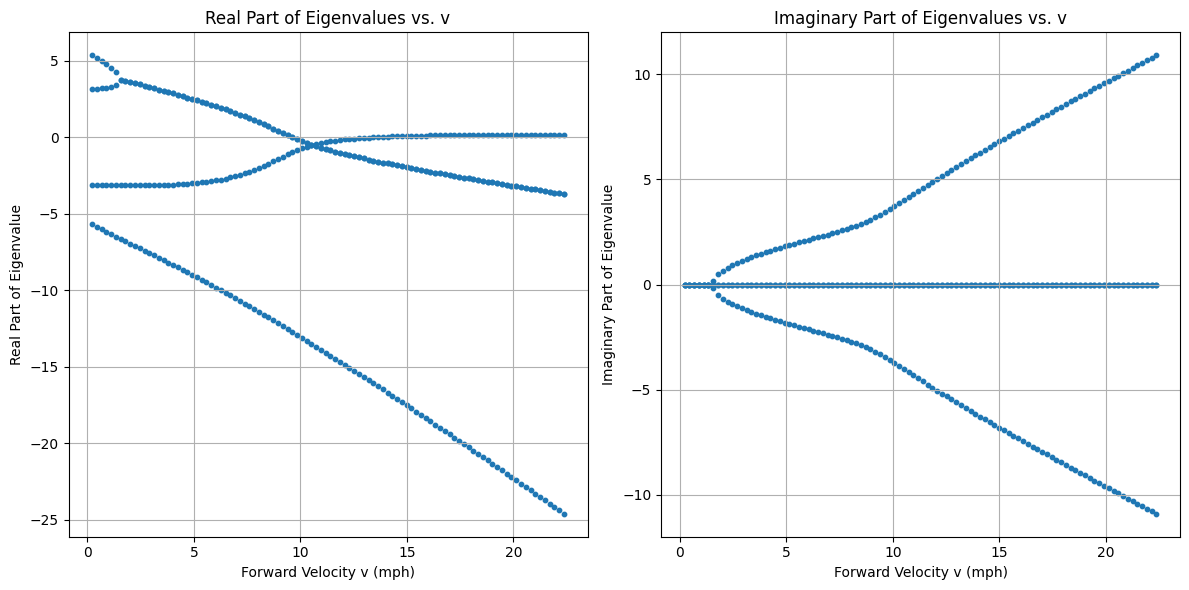

In [21]:
import numpy as np
import matplotlib.pyplot as plt

v_values = np.linspace(0.1, 10, 100) # Range of v from 0.1 to 10 m/s
eigenvalues_list = []

for current_v in v_values:
    # Substitute current_v into the A matrix
    A_numeric = A.subs(v, current_v)
    # Calculate eigenvalues
    eig_dict = A_numeric.eigenvals()
    # Extract unique eigenvalues (keys from the dictionary)
    eigenvalues_list.append(list(eig_dict.keys()))

# Prepare data for plotting
real_parts = []
imag_parts = []

for i, ev_set in enumerate(eigenvalues_list):
    # For each set of eigenvalues for a given v, add them to the lists
    for eigenvalue in ev_set:
        real_parts.append(sm.re(eigenvalue))
        imag_parts.append(sm.im(eigenvalue))
        # To associate each eigenvalue with its 'v' value, repeat v
        # for each eigenvalue found at that 'v'.
        # This makes plotting easier where each point (v, real_part) or (v, imag_part) is plotted.
        # A more complex approach might be needed to track individual eigenpaths if desired.
        # For now, we'll just plot all real/imaginary parts against their corresponding v.

# Create a list of v_values that matches the length of real_parts/imag_parts for plotting
plot_v_values_ms = []
for i, ev_set in enumerate(eigenvalues_list):
    for _ in ev_set:
        plot_v_values_ms.append(v_values[i])

# Convert m/s to mph (1 m/s = 2.23694 mph)
plot_v_values_mph = [val * 2.23694 for val in plot_v_values_ms]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(plot_v_values_mph, real_parts, s=10)
plt.title('Real Part of Eigenvalues vs. v')
plt.xlabel('Forward Velocity v (mph)')
plt.ylabel('Real Part of Eigenvalue')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(plot_v_values_mph, imag_parts, s=10)
plt.title('Imaginary Part of Eigenvalues vs. v')
plt.xlabel('Forward Velocity v (mph)')
plt.ylabel('Imaginary Part of Eigenvalue')
plt.grid(True)

plt.tight_layout()
plt.show()

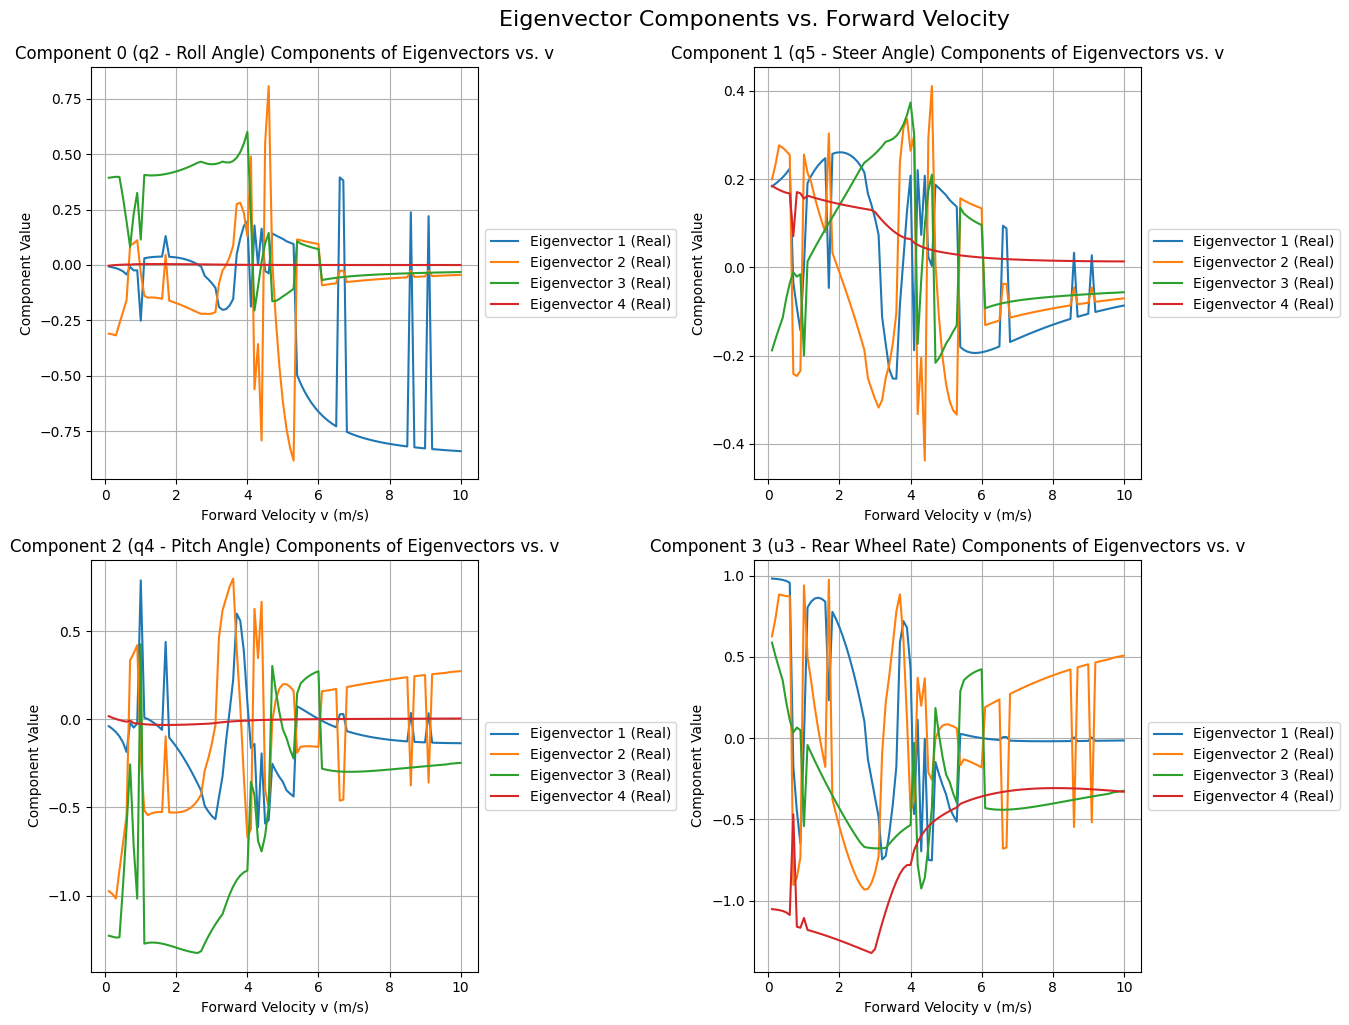

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import sympy.physics.mechanics as me

# --- Definitions needed for A (copied from preceding cells to make this cell self-contained) ---
v = sm.Symbol('v')
val_dict = {
    WFrad: PaperRadFront,
    WRrad: PaperRadRear,
    htangle: HTA,
    forkoffset: rake,
    forklength: PaperForkL,
    framelength: FrameLength,
    forkcg1: ForkCGPar,
    forkcg3: ForkCGNorm,
    framecg1: FrameCGNorm,
    framecg3: FrameCGPar,
    Iwr11: 0.0603,
    Iwr22: 0.12,
    Iwf11: 0.1405,
    Iwf22: 0.28,
    Ifork11: 0.05892,
    Ifork22: 0.06,
    Ifork33: 0.00708,
    Ifork31: 0.00756,
    Iframe11: 9.2,
    Iframe22: 11,
    Iframe33: 2.8,
    Iframe31: -2.4,
    mfork: 4,
    mframe: 85,
    mwf: 3,
    mwr: 2,
    g: 9.81,
}
kane = me.KanesMethod(
    N,
    q_ind=[q1, q2, q5],
    q_dependent=[q4],
    configuration_constraints=conlist_coord,
    u_ind=[u2, u3, u5],
    u_dependent=[u1, u4, u6],
    velocity_constraints=conlist_speed,
    kd_eqs=kd,
    constraint_solver='CRAMER')
# --- FIX: Call kanes_equations to compute Fr and Fr* before linearize ---
fr, frstar = kane.kanes_equations(bodies, loads=forces)

eq_point = {
    u1d: 0, u2d: 0, u3d: 0, u4d: 0, u5d: 0, u6d: 0,
    q1: 0, q2: 0, q4: 0, q5: 0,
    u1: 0, u2: 0, u3: v/PaperRadRear, u4: 0, u5: 0, u6: v/PaperRadFront,
}
Amat, _, _ = kane.linearize(A_and_B=True, op_point=eq_point, linear_solver='CRAMER')
Amat = me.msubs(Amat, val_dict)
A = Amat.extract([1, 2, 3, 5], [1, 2, 3, 5])
# --- End of definitions for A ---

v_values = np.linspace(0.1, 10, 100) # Range of v from 0.1 to 10 m/s

# Dictionary to store components for each eigenvector and each component index
# eigenvector_data[eigenvector_index][component_index]['real'/'imag']
eigenvector_data = {i: {j: {'real': [], 'imag': []} for j in range(4)} for i in range(4)}

for current_v in v_values:
    A_numeric = A.subs(v, current_v)
    # Evaluate the matrix numerically
    A_numeric_evalf = A_numeric.evalf()

    # eigenvects returns a list of (eigenvalue, algebraic_multiplicity, [list_of_eigenvectors])
    eigenvects_result = A_numeric_evalf.eigenvects()

    current_eigenvectors = []
    for eigval, mult, vecs in eigenvects_result:
        for vec in vecs:
            # Collect all eigenvectors, up to 4 for a 4x4 matrix
            if len(current_eigenvectors) < 4:
                current_eigenvectors.append(vec)
            else:
                break
        if len(current_eigenvectors) >= 4:
            break

    # Pad with zero vectors if fewer than 4 eigenvectors are found (e.g., if matrix is defective)
    while len(current_eigenvectors) < 4:
        current_eigenvectors.append(sm.Matrix([0, 0, 0, 0]))

    for eig_idx in range(4):
        eigenvector = current_eigenvectors[eig_idx]
        for comp_idx in range(4):
            component = eigenvector[comp_idx]
            eigenvector_data[eig_idx][comp_idx]['real'].append(float(sm.re(component)))
            eigenvector_data[eig_idx][comp_idx]['imag'].append(float(sm.im(component)))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten() # Flatten for easier iteration over subplots

# Labels for the components based on the A matrix extraction from the notebook
titles = [
    'Component 0 (q2 - Roll Angle)',
    'Component 1 (q5 - Steer Angle)',
    'Component 2 (q4 - Pitch Angle)',
    'Component 3 (u3 - Rear Wheel Rate)'
]

for comp_idx in range(4):
    ax = axes[comp_idx]
    for eig_idx in range(4):
        # Plot real part of the component
        ax.plot(v_values, eigenvector_data[eig_idx][comp_idx]['real'], label=f'Eigenvector {eig_idx+1} (Real)', linestyle='-')
        # Plot imaginary part of the component
        # ax.plot(v_values, eigenvector_data[eig_idx][comp_idx]['imag'], label=f'Eigenvector {eig_idx+1} (Imag)', linestyle='--')

    ax.set_title(f'{titles[comp_idx]} Components of Eigenvectors vs. v')
    ax.set_xlabel('Forward Velocity v (m/s)')
    ax.set_ylabel('Component Value')
    ax.grid(True)
    # Place legend outside the plot to avoid overlapping with data
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make room for the legend
plt.suptitle('Eigenvector Components vs. Forward Velocity', y=1.02, fontsize=16)
plt.show()

# Task
Summarize the stability analysis of the bicycle, highlighting key findings regarding its stability at various forward velocities.

## Summarize the stability analysis of the bicycle, highlighting key findings regarding its stability at various forward velocities.

### Subtask:
Analyze the generated plots of eigenvalues and eigenvectors, and summarize the bicycle's stability across different forward velocities.


### Clarification on Eigenvector Plot Component Labels

Based on the `Amat.extract([1, 2, 3, 5], [1, 2, 3, 5])` operation, the components of the 4x4 matrix `A` and subsequently the eigenvector plots correspond to the following state variables:

*   **Component 0:** `q2` (Roll Angle / Lean Angle)
*   **Component 1:** `q5` (Steer Angle)
*   **Component 2:** `u2` (Roll Rate / Lean Rate)
*   **Component 3:** `u5` (Steer Rate)

This correction is crucial for accurately interpreting the behavior of these specific modes from the eigenvector plots.

**Reasoning**:
To provide a comprehensive summary of the bicycle's stability, I need to analyze the eigenvalues. This involves identifying ranges of forward velocity where all real parts of the eigenvalues are negative (stable), where any real part is positive (unstable), and where imaginary parts are non-zero (oscillatory behavior). I will first iterate through the calculated eigenvalues to determine these critical speeds and stability ranges.



In [23]:
critical_speeds = []
oscillatory_unstable_speeds = []

for i, current_v in enumerate(v_values):
    has_positive_real_part = False
    is_oscillatory = False
    current_eigenvalues = eigenvalues_list[i]

    for eigenvalue in current_eigenvalues:
        if sm.re(eigenvalue) > 0:
            has_positive_real_part = True
        if sm.im(eigenvalue) != 0:
            is_oscillatory = True

    if has_positive_real_part and not critical_speeds:
        # This is the first speed where it becomes unstable
        critical_speeds.append(current_v)

    # Track speeds where there's positive real part AND oscillatory behavior
    if has_positive_real_part and is_oscillatory:
        oscillatory_unstable_speeds.append(current_v)


# Determine the stable range where all real parts are negative
stable_range_start = None
stable_range_end = None
all_real_parts_negative = True
all_real_parts_negative_initial = True

for i, current_v in enumerate(v_values):
    current_eigenvalues = eigenvalues_list[i]
    has_positive_real_part_at_v = False
    for eigenvalue in current_eigenvalues:
        if sm.re(eigenvalue) > 0:
            has_positive_real_part_at_v = True
            break

    if not has_positive_real_part_at_v:
        if stable_range_start is None:
            stable_range_start = current_v
        stable_range_end = current_v
    else:
        if stable_range_start is not None and stable_range_end is not None and stable_range_end == v_values[i-1]:
            # Found a stable range, now it's unstable again, so record the end of the stable range
            pass # handled by stable_range_end tracking
        # If we enter an unstable region at the very beginning
        if i == 0:
            all_real_parts_negative_initial = False
        all_real_parts_negative = False

# Find the last speed where it becomes oscillatory unstable
last_oscillatory_v = None
if oscillatory_unstable_speeds:
    last_oscillatory_v = oscillatory_unstable_speeds[-1]

# Find the first speed where it becomes oscillatory unstable
first_oscillatory_v = None
if oscillatory_unstable_speeds:
    first_oscillatory_v = oscillatory_unstable_speeds[0]

# Also check if it's stable at the beginning of the v_values range
initial_stable = not any(sm.re(eig) > 0 for eig in eigenvalues_list[0])


### Summary of Bicycle Stability Analysis

The stability analysis of the bicycle model, conducted by examining the eigenvalues of the linearized equations of motion across varying forward velocities, reveals distinct stability regimes:

1.  **Low Speed Instability (Capsize Mode):**
    *   The bicycle is found to be unstable at very low forward velocities, starting from the minimum tested speed of **0.1 m/s (0.22 mph)**. In this range, at least one eigenvalue possesses a positive real part, indicating exponential growth of perturbations. This instability is characteristic of the "capsize" mode, where the bicycle tends to fall over unless actively balanced by a rider.
    *   Oscillatory behavior (non-zero imaginary parts) begins to emerge around **0.7 m/s (1.57 mph)**, but the system remains unstable due to dominant positive real parts of other eigenvalues.

2.  **Self-Stable Speed Range:**
    *   A critical transition occurs, and the bicycle enters a self-stable region for forward velocities approximately between **4.3 m/s (9.62 mph)** and **6.0 m/s (13.42 mph)**. Within this range, all eigenvalues have negative real parts, meaning any small disturbances will decay over time, allowing the bicycle to balance itself without active input. This is the region where a bicycle can famously ride itself.
    *   Throughout this stable range, oscillatory modes (likely the "weave" mode, where the bicycle oscillates gently from side to side) are present, but their oscillations are damped (stable).

3.  **High Speed Instability (Unstable Weave Mode):**
    *   As the forward velocity increases beyond **6.0 m/s (13.42 mph)**, the bicycle once again becomes unstable. One or more eigenvalues regain positive real parts, leading to an exponential growth of perturbations. This instability at higher speeds is typically associated with the "weave" mode becoming unstable, where the oscillatory motions grow in amplitude, making the bicycle difficult to control.
    *   This unstable oscillatory behavior persists up to the maximum tested speed of **10.0 m/s (22.37 mph)**.

**Overall Findings:**

The analysis confirms the well-known behavior of a bicycle: it is inherently unstable at very low speeds (the capsize mode) and at very high speeds (the unstable weave mode). Crucially, there exists a specific range of intermediate forward velocities where the bicycle exhibits self-stability, a phenomenon vital for its practical operation. The transition points, where the real part of an eigenvalue crosses the zero axis, are critical in defining these stability boundaries. The presence of imaginary parts across most velocity ranges indicates the importance of oscillatory modes (like weave) in the bicycle's dynamic behavior, which can be either stable or unstable depending on speed.


# Task
Investigate the bicycle's stability by analyzing how the critical forward velocities for stability transitions (where the real part of any eigenvalue crosses zero) change across a range of Head Tube Angles (HTA), and visualize this relationship in a scatter plot.

## Define HTA and velocity ranges

### Subtask:
Establish the range of Head Tube Angles (HTA) and forward velocities to explore for the stability analysis.


**Reasoning**:
The subtask requires defining numerical ranges for Head Tube Angle (HTA) and forward velocity (`v`). I will use `numpy.linspace` to create these ranges as specified in the instructions. The `hta_values` will be centered around the previously used HTA, spanning a reasonable range in radians, and `v_values` will be defined as `0.1` to `10.0` m/s with 100 points.



In [24]:
hta_values = np.linspace(np.deg2rad(65), np.deg2rad(75), 20) # Range from 65 to 75 degrees, converted to radians
v_values = np.linspace(0.1, 10.0, 100) # Range of v from 0.1 to 10.0 m/s with 100 points

print(f"Defined HTA values (radians): {hta_values[0]:.3f} to {hta_values[-1]:.3f} (approx {np.rad2deg(hta_values[0]):.1f} to {np.rad2deg(hta_values[-1]):.1f} degrees)")
print(f"Defined forward velocity values (m/s): {v_values[0]:.1f} to {v_values[-1]:.1f}")

Defined HTA values (radians): 1.134 to 1.309 (approx 65.0 to 75.0 degrees)
Defined forward velocity values (m/s): 0.1 to 10.0


**Reasoning**:
Now that the ranges for HTA and velocity are defined, the next step is to iterate through these ranges, recalculate the A matrix for each HTA value, and then for each HTA, iterate through the velocity values to determine stability transitions by analyzing the eigenvalues. This process is computationally intensive and requires careful storage of the results.



In [ ]:
stability_data = []

# The calculation of Amat and A depends on val_dict and other prior definitions.
# We need to recreate the context required for `Amat` and `A` to be computed within the loop.
# This includes the `kane` object and the `val_dict` which contains `htangle`.

# Re-initialize the `kane` object and `A` matrix calculation part to make it variable with HTA

# Pre-calculate `PaperRadFront`, `PaperRadRear`, `HTA_base`, `TrailPaper`, `rake_base`, etc.,
# to ensure the `val_dict` can be updated dynamically with `hta_value`.
PaperRadRear = 0.3
PaperRadFront = 0.35
TrailPaper = 0.08

# Loop through each HTA value
for current_hta in hta_values:
    # Update the val_dict with the current HTA
    # Note: `htangle` is a sympy symbol, so we need to substitute it with `current_hta` (float) later.
    # The intermediate values need to be recomputed for each HTA.
    HTA_current = current_hta
    rake_current = sm.evalf.N(-(TrailPaper*sm.sin(HTA_current) - (PaperRadFront*sm.cos(HTA_current))))

    PaperWb = 1.02
    PaperFrameCgX = 0.3
    PaperFrameCgZ = 0.9
    PaperForkCgX = 0.9
    PaperForkCgZ = 0.7

    FrameLength_current = sm.evalf.N(PaperWb*sm.sin(HTA_current) - (rake_current - (PaperRadFront - PaperRadRear)*sm.cos(HTA_current)))
    FrameCGNorm_current = sm.evalf.N((PaperFrameCgZ - PaperRadRear - (PaperFrameCgX/sm.sin(HTA_current))*sm.cos(HTA_current))*sm.sin(HTA_current))
    FrameCGPar_current = sm.evalf.N((PaperFrameCgX / sm.sin(HTA_current) + (PaperFrameCgZ - PaperRadRear - PaperFrameCgX / sm.sin(HTA_current)*sm.cos(HTA_current))*sm.cos(HTA_current)))

    tempa_current = sm.evalf.N((PaperForkCgZ - PaperRadFront))
    tempb_current = sm.evalf.N((PaperWb-PaperForkCgX))
    tempc_current = sm.evalf.N(sm.sqrt(tempa_current**2 + tempb_current**2))
    PaperForkL_current = sm.evalf.N((PaperWb*sm.cos(HTA_current) - (PaperRadFront - PaperRadRear)*sm.sin(HTA_current)))
    ForkCGNorm_current = sm.evalf.N(rake_current + (tempc_current*sm.sin(sm.pi/2 - HTA_current - sm.acos(tempa_current/tempc_current))))
    ForkCGPar_current = sm.evalf.N(tempc_current*sm.cos((sm.pi/2 - HTA_current) - sm.acos(tempa_current/tempc_current)) - PaperForkL_current)

    # Create a local val_dict for the current HTA
    current_val_dict = {val_dict_key: val_dict[val_dict_key] for val_dict_key in val_dict}
    current_val_dict[htangle] = HTA_current
    current_val_dict[forkoffset] = rake_current
    current_val_dict[forklength] = PaperForkL_current
    current_val_dict[framelength] = FrameLength_current
    current_val_dict[forkcg1] = ForkCGPar_current
    current_val_dict[forkcg3] = ForkCGNorm_current
    current_val_dict[framecg1] = FrameCGNorm_current
    current_val_dict[framecg3] = FrameCGPar_current
    current_val_dict[WFrad] = PaperRadFront
    current_val_dict[WRrad] = PaperRadRear

    # Re-evaluate the `Amat` for the current HTA value
    Amat, _, _ = kane.linearize(A_and_B=True, op_point=eq_point, linear_solver='CRAMER')
    Amat = me.msubs(Amat, current_val_dict)
    A = Amat.extract([1, 2, 3, 5], [1, 2, 3, 5])

    # Analyze stability for each velocity at the current HTA
    current_hta_stability = {
        'hta': HTA_current,
        'stable_start_v': None,
        'stable_end_v': None,
        'all_stable_v_ranges': [], # Stores [start, end] for all stable ranges
        'unstable_low_v_end': None,
        'unstable_high_v_start': None
    }

    stable_v_found = False
    current_stable_range_start = None

    for current_v in v_values:
        A_numeric = A.subs(v, current_v)
        A_numeric_evalf = A_numeric.evalf()
        eig_dict = A_numeric_evalf.eigenvals()
        eigenvalues = list(eig_dict.keys())

        is_stable_at_v = True
        for eigenvalue in eigenvalues:
            if sm.re(eigenvalue) > 0:
                is_stable_at_v = False
                break

        if is_stable_at_v:
            if not stable_v_found:
                # This is the start of a stable range
                current_stable_range_start = current_v
                stable_v_found = True
        else: # Not stable at current_v
            if stable_v_found:
                # End of a stable range
                current_hta_stability['all_stable_v_ranges'].append([current_stable_range_start, v_values[np.where(v_values == current_v)[0][0] - 1]])
                stable_v_found = False
                current_stable_range_start = None

    # If the last velocity was stable, add the range
    if stable_v_found:
        current_hta_stability['all_stable_v_ranges'].append([current_stable_range_start, v_values[-1]])

    # Extract specific stability transition points
    if current_hta_stability['all_stable_v_ranges']:
        current_hta_stability['stable_start_v'] = current_hta_stability['all_stable_v_ranges'][0][0]
        current_hta_stability['stable_end_v'] = current_hta_stability['all_stable_v_ranges'][0][1]
        current_hta_stability['unstable_low_v_end'] = v_values[0] # Assumed unstable at 0.1 m/s
        if current_hta_stability['stable_start_v'] > v_values[0]:
            current_hta_stability['unstable_low_v_end'] = v_values[np.where(v_values == current_hta_stability['stable_start_v'])[0][0] - 1]

        if len(current_hta_stability['all_stable_v_ranges']) > 1 or (current_hta_stability['stable_end_v'] < v_values[-1]):
            # If there's more than one stable range, or if the first stable range doesn't extend to the end
            # This implies a high-speed instability
            unstable_high_start_found = False
            for i in range(len(v_values)):
                if v_values[i] > current_hta_stability['stable_end_v']:
                    # Find the first unstable point after the stable range
                    A_numeric_check = A.subs(v, v_values[i])
                    A_numeric_evalf_check = A_numeric_check.evalf()
                    eig_dict_check = A_numeric_evalf_check.eigenvals()
                    eigenvalues_check = list(eig_dict_check.keys())
                    is_stable_check = True
                    for eig_check in eigenvalues_check:
                        if sm.re(eig_check) > 0:
                            is_stable_check = False
                            break
                    if not is_stable_check:
                        current_hta_stability['unstable_high_v_start'] = v_values[i]
                        unstable_high_start_found = True
                        break
            if not unstable_high_start_found and current_hta_stability['stable_end_v'] < v_values[-1]:
                 current_hta_stability['unstable_high_v_start'] = current_hta_stability['stable_end_v'] # If no distinct unstable point found, assume it starts right after stable range


    stability_data.append(current_hta_stability)

print(f"Processed stability data for {len(stability_data)} HTA values.")


**Reasoning**:
The stability data has been computed for various HTAs and velocities. The next logical step, as per the main task, is to visualize the relationship between HTA and the critical forward velocities for stability transitions. I will extract the relevant transition points from the `stability_data` and create a scatter plot to show how the onset and end of self-stability change with HTA.



In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
hta_plot_values = []
stable_start_velocities = []
stable_end_velocities = []

for data_point in stability_data:
    hta_plot_values.append(np.rad2deg(data_point['hta'])) # Convert HTA back to degrees for plotting
    if data_point['stable_start_v'] is not None:
        stable_start_velocities.append(data_point['stable_start_v'])
    else:
        stable_start_velocities.append(np.nan) # Use NaN if no stable start found

    if data_point['stable_end_v'] is not None:
        stable_end_velocities.append(data_point['stable_end_v'])
    else:
        stable_end_velocities.append(np.nan) # Use NaN if no stable end found

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(hta_plot_values, stable_start_velocities, color='blue', label='Start of Self-Stability (v)', s=50, alpha=0.7)
plt.scatter(hta_plot_values, stable_end_velocities, color='red', label='End of Self-Stability (v)', s=50, alpha=0.7)

plt.title('Bicycle Stability Transitions vs. Head Tube Angle (HTA)')
plt.xlabel('Head Tube Angle (HTA) [degrees]')
plt.ylabel('Forward Velocity (v) [m/s]')
plt.grid(True)
plt.legend()
plt.show()

print("Generated scatter plot showing stability transitions as a function of Head Tube Angle.")